In [1]:
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

2023-03-07 14:06:29.010528: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 14:06:29.424340: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-07 14:06:29.424377: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-07 14:06:30.827727: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Notes:
    
Converting images to numpy array

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import save_model, load_model
from keras.optimizers import Adam
from tensorflow.keras.layers import Normalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, SimpleRNN, Flatten
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Masking


Plan:

1) load 1 image in 
2) look at it
3) resize it 

4) create uber basic CNN that is happy to take it as input

5) point it at more images

6) get it on google colab

Questions


In [3]:
path_to_dataset = os.path.join("..", "data", "raw_data","kaggle_ingredients", "test_miniset")

path_to_mini_dataset= os.path.join("..", "data", "raw_data", "test_miniset")

batch_size = 16 #None #16 #32
img_height = 180
img_width = 180

X_train_ds = image_dataset_from_directory(
  path_to_mini_dataset,
  validation_split=0.2,
  label_mode="int",
  subset="training",
  color_mode="rgb",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15462 files belonging to 5 classes.
Using 12370 files for training.


2023-03-07 14:06:38.205762: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-07 14:06:38.206674: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-07 14:06:38.206761: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Louis-Laptop-Lenovo): /proc/driver/nvidia/version does not exist
2023-03-07 14:06:38.211496: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
X_val_ds = image_dataset_from_directory(
  path_to_mini_dataset,
  validation_split=0.2,
  label_mode="int",
  subset="validation",
  color_mode="rgb",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#images = image_dataset_from_directory(path_to_dataset, )

Found 15462 files belonging to 5 classes.
Using 3092 files for validation.


In [5]:
count = 0
test_image, test_label = None, None

for image, label in X_train_ds.take(1):
    if count == 0 :
        test_image = image.numpy()
        test_label = label.numpy()
    count+=1
    if count > 0: break
print("test label shape: ", test_label.shape)
print(test_label)
print("image shape:" ,test_image.shape)

test label shape:  (16,)
[3 2 0 3 0 3 0 0 0 0 0 2 3 0 3 4]
image shape: (16, 180, 180, 3)


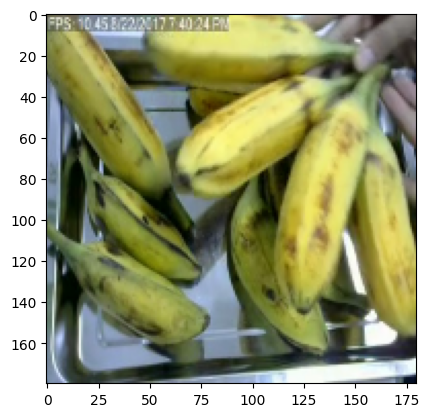

In [6]:
plt.imshow(test_image[0]/255)

In [7]:
#getting label out?

test_image.shape
test_label

array([3, 2, 0, 3, 0, 3, 0, 0, 0, 0, 0, 2, 3, 0, 3, 4], dtype=int32)

## CNN

### prepare + initial declarations


In [8]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import save_model, load_model
from keras.optimizers import Adam
from tensorflow.keras.layers import Normalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, SimpleRNN, Flatten
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Masking

In [9]:
in_shape = test_image[0].shape
in_shape

(180, 180, 3)

In [10]:
num_classes = len(X_train_ds.class_names)
num_classes

5

### Declare model

In [11]:
model = models.Sequential()

#normalise the inputs
model.add(layers.Rescaling(1./255))

#first convolutional layer - big kernels, few filters
model.add(layers.Conv2D(16, kernel_size=(5,5), padding="same", activation="relu", input_shape=in_shape))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#second conv layer
model.add(layers.Conv2D(32, kernel_size=(4,4), padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#third conv layer
model.add(layers.Conv2D(64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten
model.add(layers.Flatten())

#Dense layers - do we regularise the kernels?!
model.add(layers.Dense(64, activation="relu"))#, kernel_regularizer=reg_l1_l2))
model.add(layers.Dropout(0.2) )
model.add(layers.Dense(32, activation="relu"))#, kernel_regularizer=reg_l1_l2))
model.add(layers.Dropout(0.2) )
model.add(layers.Dense(16, activation="relu"))#, kernel_regularizer=reg_l1_l2))
model.add(layers.Dropout(0.2) ) 

#Last layer, convert for appropriate model output
model.add(layers.Dense(num_classes, activation="softmax"))


In [12]:
#Compile model

#loss could be sparse cat crossentropy?
#https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy

loss = "sparse_categorical_crossentropy"
optimizer = "adam"
metrics = ["accuracy"]
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

#prep for early stopping
es = EarlyStopping(patience=20, restore_best_weights=True)


In [13]:
#fit model
model.fit(
        X_train_ds, 
        validation_data=X_val_ds, 
        epochs=50, 
        callbacks=[es], 
        verbose=1
    )

Epoch 1/50
  9/774 [..............................] - ETA: 3:04 - loss: 1.4720 - accuracy: 0.4861

KeyboardInterrupt: 